# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


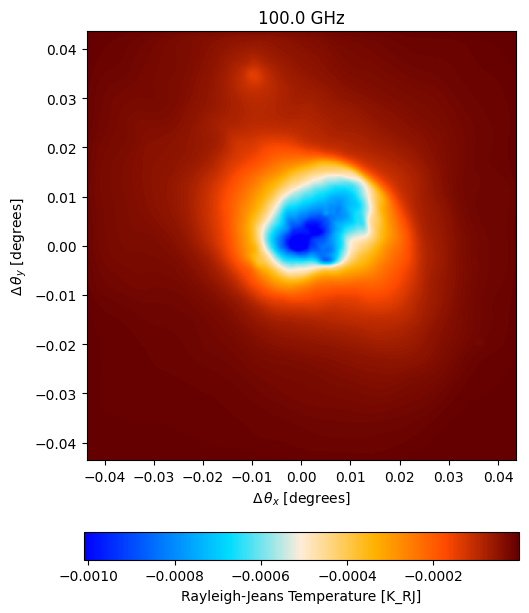

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

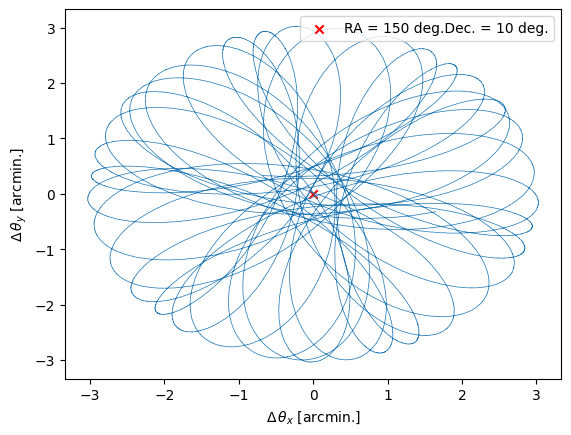

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-11-04 11:21:46.679 INFO: Initialized base in 1454 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]
2024-11-04 11:21:52.184 INFO: Initialized atmosphere in 5493 ms.
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


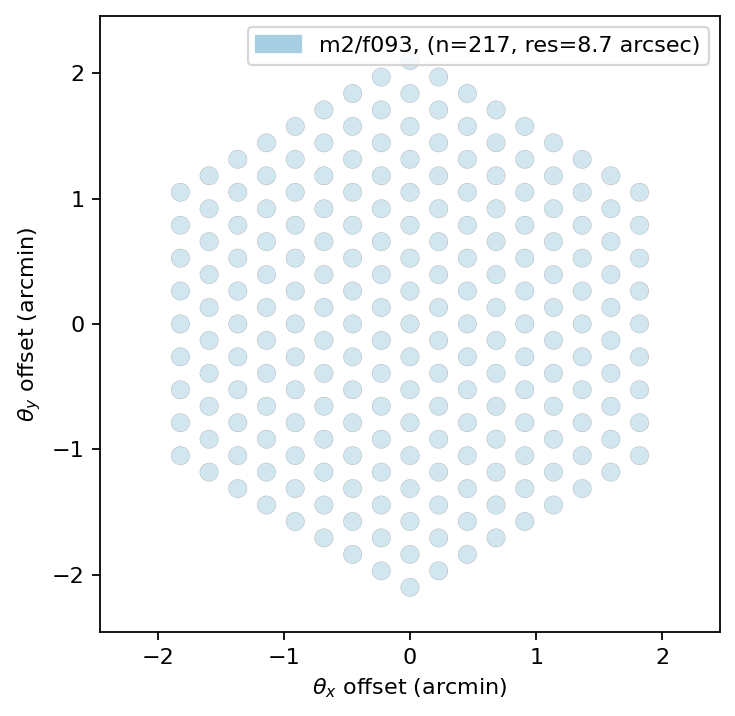

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.21s/it]


mapdata_truth shape: (1, 1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


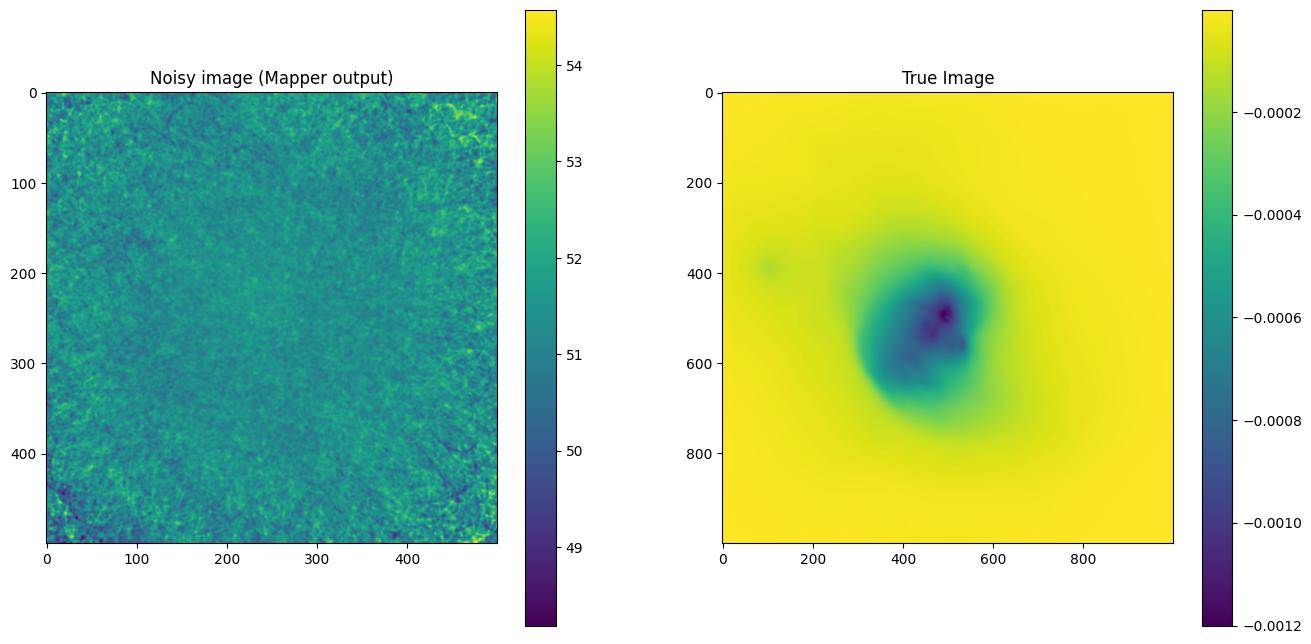

In [5]:
from maria.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 1}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0, 0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-11-04 11:22:05.428 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-11-04 11:22:05.429 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Test TOD agreement:

TRJ.shape: (64, 1, 1000, 1000)


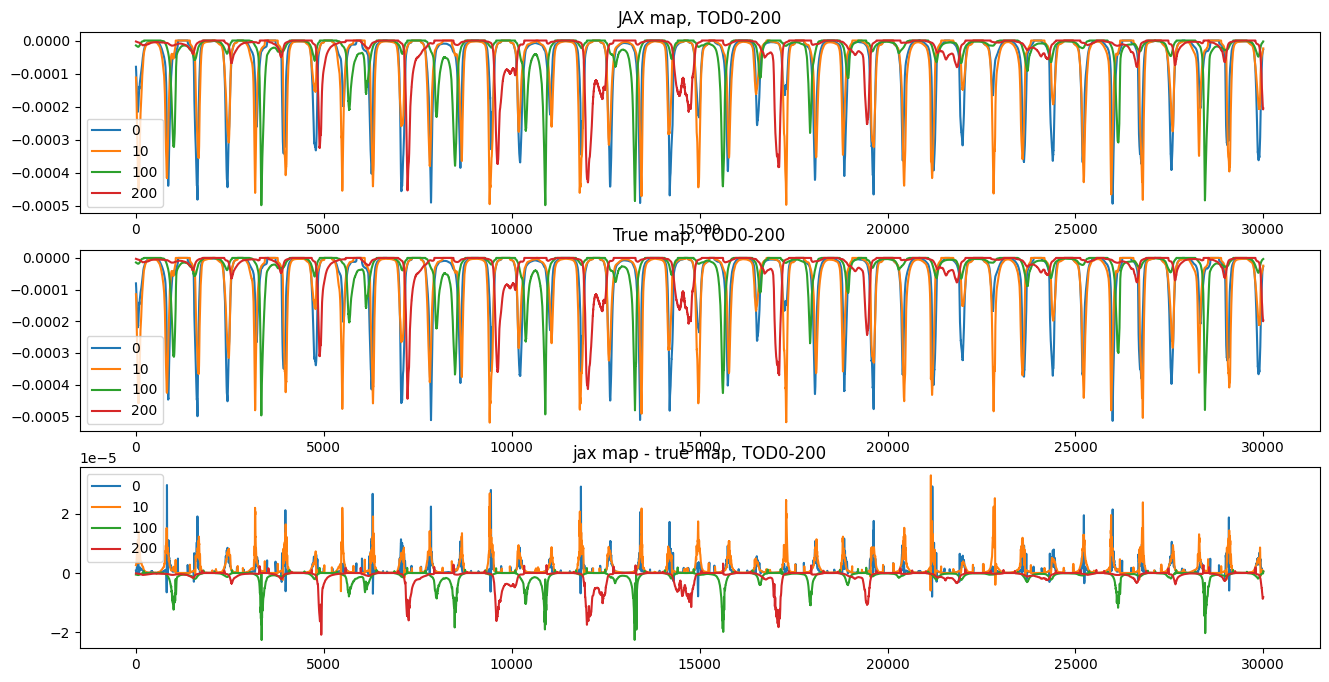

In [7]:
jax_tods_map = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)

    tods_map = np.float64(tod_truthmap.get_field('map').compute())
    im1 = axes[1].plot(tods_map[i], label=i)

    im2 = axes[2].plot(jax_tods_map[i] - tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX map, TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True map, TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'jax map - true map, TOD0-{i}')
axes[2].legend()

plt.show()

# Prepare noised input TODs:

Noise stddev: 0.00025217976329378625


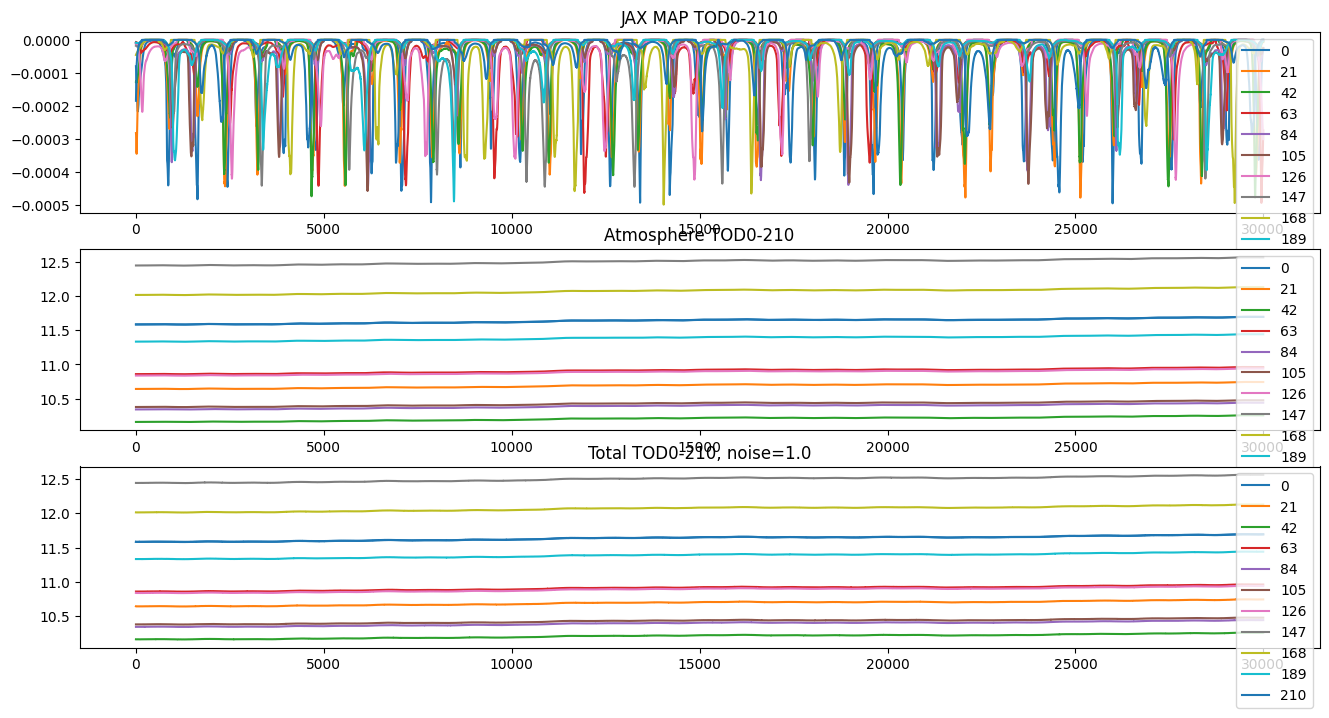

In [8]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

# Add n TODs for atmos:
n = jax_tods_map.shape[0]

jax_tods_atmos = tod_truthmap.get_field('atmosphere')
# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.get_field('noise')*noiselevel)
# noised_jax_tod = np.float64(tod_truthmap.get_field('noise')*noiselevel)
noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 

denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10):
    im0 = axes[0].plot(jax_tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i], label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

## Test atmosphere slopes:

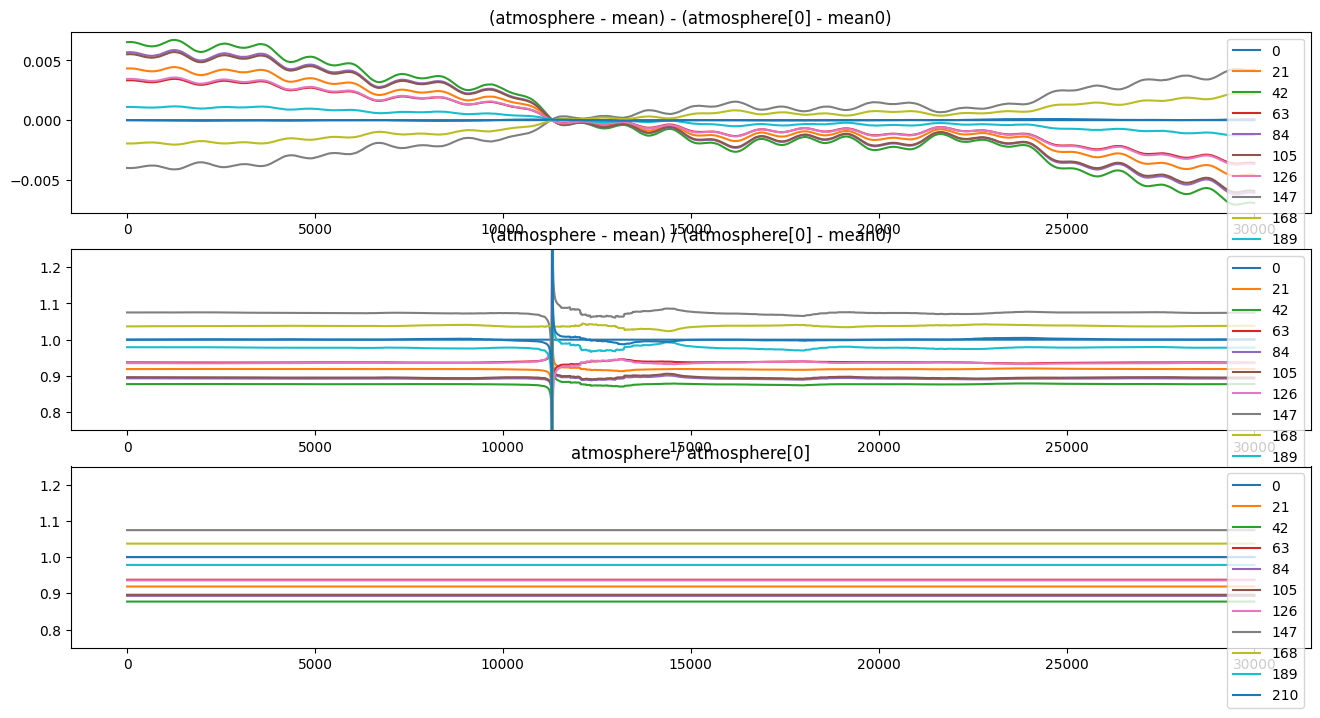

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    axes[0].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean() - (jax_tods_atmos[0] - jax_tods_atmos[0].mean()), label=i)
    axes[1].plot( (jax_tods_atmos[i] - jax_tods_atmos[i].mean()) / (jax_tods_atmos[0] - jax_tods_atmos[0].mean()), label=i)
    axes[2].plot(jax_tods_atmos[i]/jax_tods_atmos[0], label=i)
    
axes[0].title.set_text(f'(atmosphere - mean) - (atmosphere[0] - mean0)')
axes[0].legend()
axes[1].title.set_text(f'(atmosphere - mean) / (atmosphere[0] - mean0)')
axes[1].legend()
axes[1].set_ylim([0.75, 1.25])
axes[2].title.set_text(f'atmosphere / atmosphere[0]')
axes[2].legend()
axes[2].set_ylim([0.75, 1.25])

plt.show()

In [10]:
print("real slopes:")
slopes_truth = (jax_tods_atmos) / (jax_tods_atmos[0])
slopes_truth = np.float64(slopes_truth.mean(axis=1))

slopes = noised_jax_tod / noised_jax_tod[0]
slopes = np.float64(slopes.mean(axis=1))
print(slopes_truth.shape)

slopes_truth - slopes

real slopes:
(217,)


array([ 0.00000000e+00,  1.91007096e-07,  1.08758202e-07, -3.50643069e-07,
       -1.59851997e-07,  7.84969427e-07, -4.93031867e-07,  2.50227409e-07,
       -8.79729662e-08,  2.02286631e-07,  2.19719154e-07, -1.27332244e-07,
       -7.15269228e-07, -3.59259303e-07, -4.60641455e-07, -8.48523524e-07,
        4.28147475e-07, -9.79039414e-07,  4.08165779e-07, -8.87537887e-07,
       -6.36459794e-07,  4.82119593e-08, -5.34993021e-07, -5.63031307e-07,
       -1.02598635e-06, -3.61194554e-07, -2.57126788e-07, -8.84186506e-07,
       -9.64585773e-07, -2.09603434e-07,  2.67536472e-07, -3.37710387e-07,
       -7.20048462e-07, -9.32292582e-07, -1.47259324e-06, -1.23108843e-06,
       -5.80937361e-07, -1.94337570e-06, -5.94673437e-07, -6.23347816e-07,
       -2.27090837e-06, -8.66184257e-07, -3.08952207e-07, -1.34143974e-06,
       -1.22283527e-06, -1.35310723e-06, -1.88912431e-06, -1.28123635e-06,
       -1.23033447e-06, -3.45587664e-07, -4.78146703e-07, -1.50580259e-06,
       -1.58373647e-06, -

np.float64(-5.949140011136042e-13)

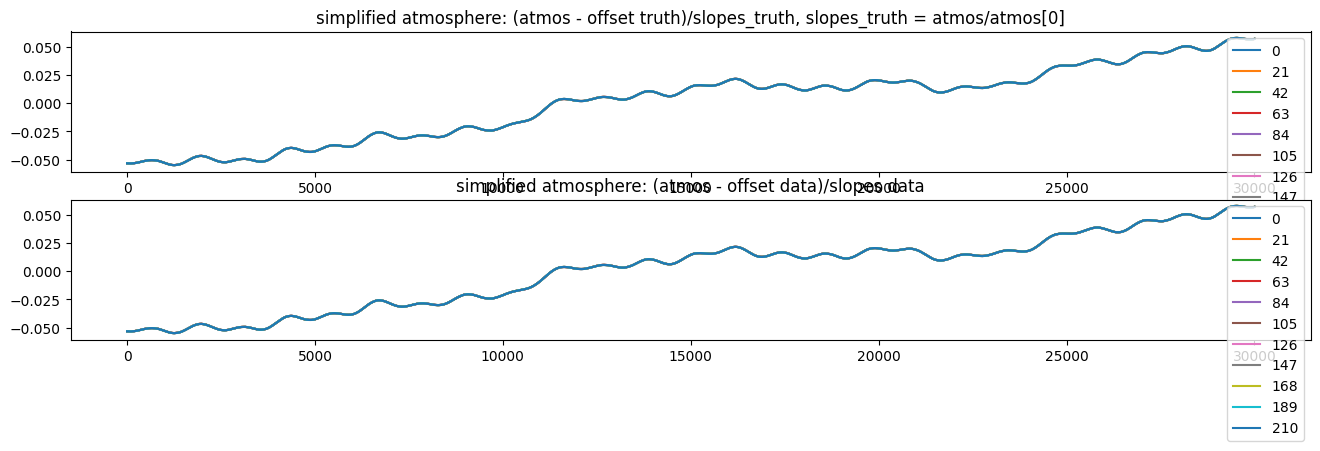

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(16, 4))

# slopes_truth = (jax_tods_atmos - jax_tods_atmos.mean(axis=1)[:, None]) / (jax_tods_atmos[0] - jax_tods_atmos[0].mean())
# slopes_truth = (jax_tods_atmos - jax_tods_atmos.mean()) / (jax_tods_atmos[0] - jax_tods_atmos.mean())

offset_tod_truth = np.float64(jax_tods_atmos.mean(axis=1))
offset_tod = np.float64(noised_jax_tod.mean(axis=1))

atmos_tod_simplified = (jax_tods_atmos - offset_tod_truth[:, None])/slopes_truth[:, None]

for i in range(0, n, n//10 if n//10 != 0 else 1):
    axes[0].plot( atmos_tod_simplified[i], label=i)
    axes[1].plot( (jax_tods_atmos[i] - offset_tod[i])/slopes[i], label=i)

axes[0].title.set_text(f'simplified atmosphere: (atmos - offset truth)/slopes_truth, slopes_truth = atmos/atmos[0]')
axes[0].legend()
axes[1].title.set_text(f'simplified atmosphere: (atmos - offset data)/slopes data')
axes[1].legend()

atmos_tod_simplified.mean().compute()

# Next, initialise nifty prior model

Start with the atmosphere TOD model. For this, we need to re-write the CorrelatedFieldMaker:

In [12]:
from modified_CFM import CFM

In [13]:
# padding_atmos = 2000
# padding_atmos = 5000
padding_atmos = 10000
dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )
# dims_atmos = ( (jax_tods_atmos.shape[1] - 200 + padding_atmos), )

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0002, 0.0001))
cf_zm_tod = dict(offset_mean=0.0, offset_std=(1e-5, 0.99e-5))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    fluctuations=(0.0015, 0.0001),
    # loglogavgslope=(-2.5, 0.5), 
    loglogavgslope=(-2.45, 0.1), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
# Custom CFM:
cfm_tod = CFM("combcf ")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
# gp_tod = cfm_tod.finalize(n)
gp_tod = cfm_tod.finalize(1)
gp_tod

Model(
	<function CFM.finalize.<locals>.correlated_field at 0x149a7412a7a0>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(1, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x149a75116700>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x149a75116700>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x149a75116700>, primals=ShapeWithDtype(shape=(1, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x149a7

## Now for the map model:

In [14]:
# padding_map = 100
# dims_map = (1000 + padding_map, 1000 + padding_map)
dims_map = (1000, 1000)

# Map model

# correlated field zero mode GP offset and stddev
cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-8, 1e-7))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    fluctuations=(5.6e-5, 1e-6), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    # loglogavgslope=(-2.5e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    loglogavgslope=(-2.5, 0.1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims_map, distances=1.0 / dims_map[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

# Define offset NormalPrior:

In [15]:
# offset_dict = dict(mean = 0.0, std = 0.6, shape=(n,))
# offset_tod = jft.NormalPrior(**offset_dict, name='offset')

# offset_tod

## TOD slope Normal Prior:

In [16]:
# slope_dict = dict(mean = 0.0, std = 0.6, shape=(n,))
# slopes_tod = jft.NormalPrior(**slope_dict, name='tod_slopes')

# Using CFM - combined

In [17]:
class Signal_TOD(jft.Model):
    def __init__(self, gp_tod, offset_tod_truth, slopes_truth, gp_map):
        self.gp_tod = gp_tod
        self.gp_map = gp_map
        self.offset_tod_truth = offset_tod_truth[:, None]
        self.slopes_truth = slopes_truth[:, None]

        # super().__init__(init = self.gp_tod.init | self.gp_map.init | self.offset_tod.init,
        #                  domain = self.gp_tod.domain | self.gp_map.domain | self.offset_tod.domain)
        super().__init__(init = self.gp_tod.init | self.gp_map.init,
                        domain = self.gp_tod.domain | self.gp_map.domain )


    def __call__(self, x):
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = self.gp_tod(x_tod)
        # res_tods = self.gp_tod(x['tod'])

        # From TOD-only fit:
        res_tods_offset = res_tods[:, padding_atmos//2:-padding_atmos//2] * self.slopes_truth + self.offset_tod_truth
        # res_tods_offset = res_tods[:, padding_atmos//2:-padding_atmos//2]

        # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1]))[:, padding_map//2:-padding_map//2, padding_map//2:-padding_map//2], dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, 1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        modified_res_map = res_map.at[:n, :].add(res_tods_offset)

        return modified_res_map

# map-only:

In [18]:
class Signal_TOD_map(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init = self.gp_map.init,
                        domain = self.gp_map.domain )

    def __call__(self, x):
        res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, 1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

        return res_map

# CFM - TOD

In [19]:
class Signal_TOD_tod(jft.Model):
    def __init__(self, gp_tod, offset_tod_truth, slopes_truth):
        self.gp_tod = gp_tod
        self.offset_tod_truth = offset_tod_truth[:, None]
        self.slopes_truth = slopes_truth[:, None]

        super().__init__(init = self.gp_tod.init,
                        domain = self.gp_tod.domain )

    def __call__(self, x):
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = self.gp_tod(x_tod)
        # res_tods = self.gp_tod(x['tod'])

        # From TOD-only fit:
        res_tods_offset = res_tods[:, padding_atmos//2:-padding_atmos//2] * self.slopes_truth + self.offset_tod_truth
        # res_tods_offset = res_tods[:, padding_atmos//2:-padding_atmos//2]


        return res_tods_offset

# Define which signal response to use:

In [ ]:
# signal_response_tod = Signal_TOD(gp_tod, offset_tod_truth, slopes_truth, gp_map) # combined with truth slopes & offsets
signal_response_tod = Signal_TOD(gp_tod, offset_tod, slopes, gp_map) # combined with data slopes & offsets
# signal_response_tod = Signal_TOD_map(gp_map) # map-only
# signal_response_tod = Signal_TOD_tod(gp_tod, offset_tod_truth, slopes_truth) # tod-only

In [21]:
# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x


# Test with simple atmos TODs:
# noised_jax_tod = np.float64(atmos_tod_simplified)[:n] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n] + np.float64(jax_tods_map)[:n]
# denoised_jax_tod = np.float64(atmos_tod_simplified)[:n]

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
print(noised_jax_tod.shape)
# truth = noised_jax_tod[:, 100:-100]

lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


(217, 30000)


In [22]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'cfmapax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapxi': ShapeWithDtype(shape=(1000, 1000), dtype=<class 'jax.numpy.float64'>),
	 'cfmapzeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(1, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'cfmapax1fluctuations': functools.partial(<function random_like at 0x149a75116700>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'cfmapax1loglogavgslope': functools.partial(<function random_like at 0x149a7

# Draw Prior sample

(217, 30000)


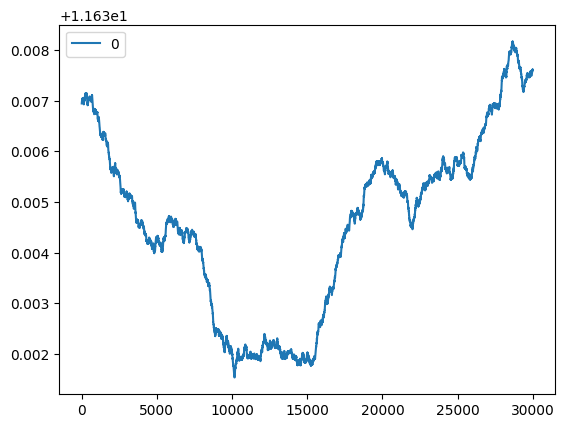

In [23]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [24]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:2.179483e+02 ➽:1.040006e+02
M: Iteration 1 ⛰:+6.047618e+08 Δ⛰:4.796153e+10
M: →:1.0 ↺:False #∇²:12 |↘|:1.081470e+02 ➽:1.040006e+02
M: Iteration 2 ⛰:+2.995362e+08 Δ⛰:3.052256e+08
M: →:1.0 ↺:False #∇²:18 |↘|:1.243453e+02 ➽:1.040006e+02
M: Iteration 3 ⛰:+7.714769e+07 Δ⛰:2.223885e+08
M: →:1.0 ↺:False #∇²:24 |↘|:5.853700e+01 ➽:1.040006e+02
M: Iteration 4 ⛰:+3.472786e+07 Δ⛰:4.241984e+07
OPTIMIZE_KL: Iteration 0001 ⛰:+3.4728e+07
OPTIMIZE_KL: #(KL minimization steps) 4
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 1.1e+01±     0.0, avg:    -0.61±     0.0, #dof:6510000'

OPTIMIZE_KL: Prior residual(s):
cfmapax1fluctuations    :: 'reduced χ²:    0.15±     0.0, avg:    -0.39±     0.0, #dof:      1'
cfmapax1loglogavgslope  :: 'reduced χ²:    0.34±     0.0, avg:    -0.58±     0.0, #dof:      1'
cfmapxi                 :: 'reduced χ²:     1.0±     0.0, avg: +0.00066±     0.0, #dof:1000000'
cfmapzeromode           :: 'reduced χ²:    0.17±    

In [25]:
samples.pos

Vector(
	{'cfmapax1fluctuations': Array(-0.3936818, dtype=float64),
	 'cfmapax1loglogavgslope': Array(-0.58326851, dtype=float64),
	 'cfmapxi': Array([[-1.03498024,  1.50636398,  0.908275  , ..., -1.0179177 ,
	         0.87347196, -1.51680155],
	       [-0.43705869,  2.11788011,  1.14542288, ..., -0.19037411,
	         0.10160375,  0.08339439],
	       [ 0.63699059,  1.01872174, -1.10033901, ...,  1.24484279,
	         0.517442  ,  1.32608458],
	       ...,
	       [-1.59149315, -0.26240053, -1.48694132, ..., -0.6323009 ,
	         1.63335419, -1.20179007],
	       [ 1.23711709,  0.66324295, -0.80813882, ...,  0.55375923,
	         0.34377241,  1.35752704],
	       [ 0.20912771,  0.30606332, -0.85370089, ...,  0.61185193,
	        -0.21284026, -0.39813459]], dtype=float64),
	 'cfmapzeromode': Array(-0.40878615, dtype=float64),
	 'combcf tod fluctuations': Array(1.14610474, dtype=float64),
	 'combcf tod loglogavgslope': Array(7.98323853, dtype=float64),
	 'combcf xi': Array([[ -0.329238

In [26]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['combcf tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['combcf tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['combcf zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    
    print("map:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_map['offset_std'])(samples.pos['cfmapzeromode'])}, {cf_zm_map['offset_std'][0]}, {cf_zm_map['offset_std'][1]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.0016153798000681056, 0.0015, 0.0001
	loglogvarslope: -1.6516761465693837, -2.45, 0.1
	zeromode std (LogNormal): 1.9356570620604937e-06, 1e-05, 9.9e-06
map:
	fluctuations: 5.5598866012653596e-05, 5.6e-05, 1e-06
	loglogvarslope: -2.5583268507813255, -2.5, 0.1
	zeromode std (LogNormal): 4.134727960902091e-10, 1e-08, 1e-07


(217, 30000)


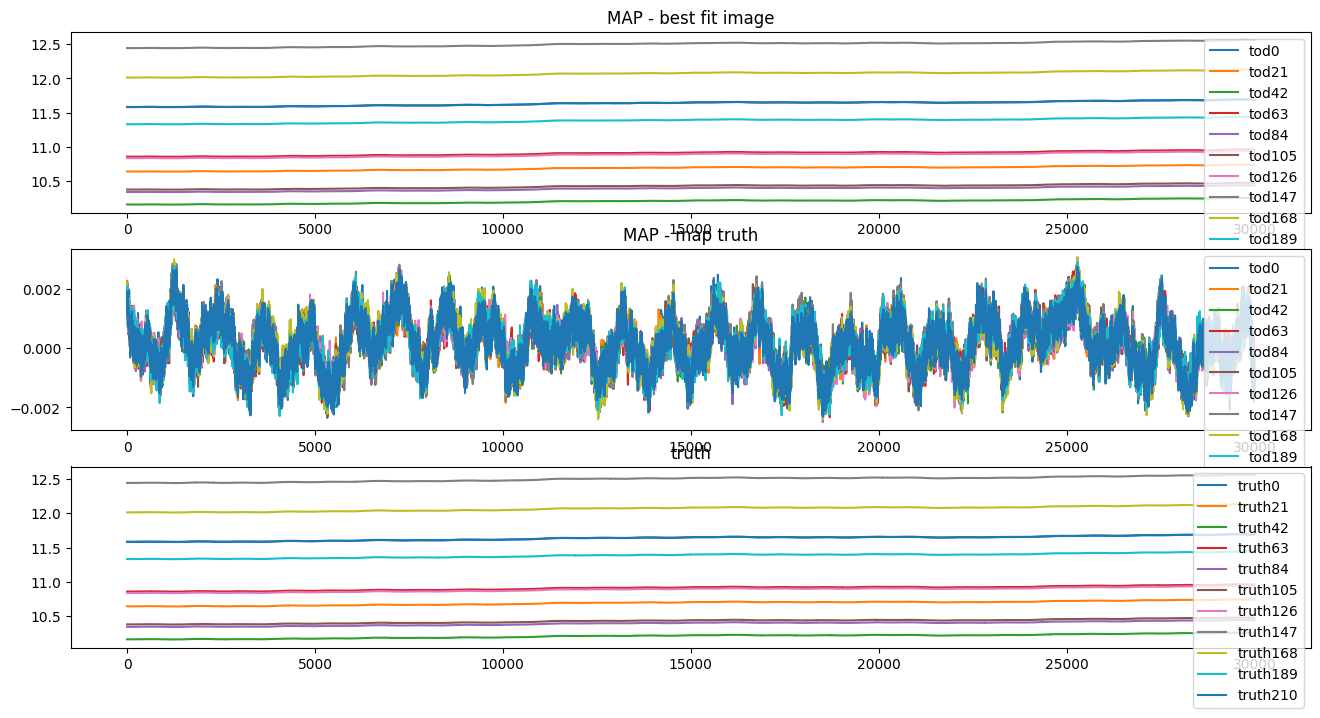

In [27]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in range(0, res.shape[0], res.shape[0]//10):
for i in range(0, n, n//10):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

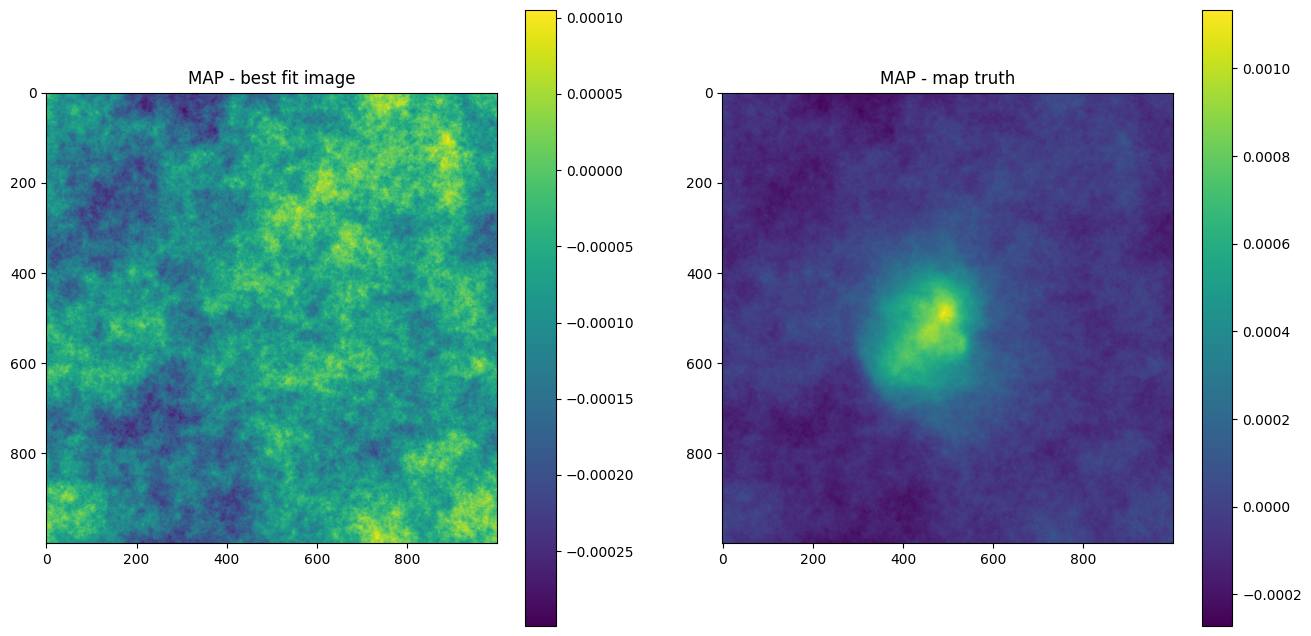

In [28]:
# plot maximum of posterior (mode)
# sig_map = gp_map(samples.pos)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] # when splitting up in different field models
sig_map = gp_map(samples.pos)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0, 0] )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

In [29]:
# assert False

## Full nifty fit:

In [31]:
n_it = 20

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    iter = opt_state[0]
    printevery = 2 #10
    if iter % printevery != 0: return

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    for i in range(0, n, n//10):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")
        # axes_tods[0].plot(denoised_jax_tod[i, 100:-100], label=f"truth{i}")
        # axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i, 100:-100], label=f"tod{i}")

    axes_tods[0].title.set_text('total mean pred. & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('total mean pred. - truth (no noise)')
    axes_tods[1].legend()

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    preds = []
    for x in samples:
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = gp_tod(x_tod)

        # From TOD-only fit:
        # preds += [res_tods[:, padding_atmos//2:-padding_atmos//2] * slopes_truth[:, None] + offset_tod_truth[:, None], ]
        preds += [res_tods[:, padding_atmos//2:-padding_atmos//2], ]

    mean_atmos, std = jft.mean_and_std(tuple(preds))

    for i in range(0, n, n//10):
        axes_tods[0].plot(np.arange(0, mean_atmos.shape[1]), mean_atmos[i], label=f"tod{i}")
        # axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[0].plot(atmos_tod_simplified[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean_atmos.shape[1]), mean_atmos[i] - atmos_tod_simplified[i], label=f"tod{i}")
        # axes_tods[1].plot(np.arange(0, mean_atmos.shape[1]), mean[i] - mean_atmos[i], label=f"tod{i}")

    axes_tods[0].title.set_text('mean atmos pred. & simplified truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean atmos pred. - simplified truth (no noise)')
    axes_tods[1].legend()

    fig_map, axes_map = plt.subplots(1, 3, figsize=(16, 6))

    # mean_map, _ = jft.mean_and_std(tuple(gp_map(s)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] for s in samples))
    mean_map, _ = jft.mean_and_std(tuple(gp_map(s) for s in samples))

    im0 = axes_map[0].imshow(mean_map)
    axes_map[0].title.set_text('mean map pred.')
    fig_map.colorbar(im0)

    im1 = axes_map[1].imshow(mean_map - mapdata_truth[0, 0])
    axes_map[1].title.set_text('mean map - truth')
    fig_map.colorbar(im1)

    im2 = axes_map[2].imshow(mapdata_truth[0, 0])
    axes_map[2].title.set_text('truth')
    fig_map.colorbar(im2)

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=20),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

OPTIMIZE_KL: Starting 0001


# Extended Model:

In [32]:
samples.pos
initial_pos = {}
for k in samples.pos:
    if k == 'combcf xi':
        initial_pos[k] = jax.numpy.broadcast_to(samples.pos['combcf xi'], (n, samples.pos['combcf xi'].shape[1]))
    else:
        initial_pos[k] = samples.pos[k]

initial_pos = jft.Vector(initial_pos)

print(initial_pos)
initial_pos['combcf xi'].shape

Vector(
	{'cfmapax1fluctuations': Array(-19.70587367, dtype=float64),
	 'cfmapax1loglogavgslope': Array(6.85400879, dtype=float64),
	 'cfmapxi': Array([[ 1.22261317e+00,  1.45704908e+01, -1.61234694e+01, ...,
	         4.90680338e-01, -3.21060137e+00,  6.73591127e+00],
	       [ 9.83346540e+00, -1.08532293e+01,  1.07119424e+01, ...,
	         2.90120255e+00, -1.23728537e-01, -4.77555352e+00],
	       [-4.84554471e+00,  6.67198469e+00, -1.12055056e+01, ...,
	        -1.13823068e+00,  2.97120202e+00, -7.43547671e-01],
	       ...,
	       [ 5.87621489e+00, -4.26979473e+00, -8.89389245e-03, ...,
	        -4.04313016e+00,  5.61697880e+00, -6.83037268e+00],
	       [-1.09394872e+01,  1.24735982e+01, -5.09195755e+00, ...,
	         2.72513244e+00, -5.24028502e+00,  9.35817838e+00],
	       [ 1.46584323e+01, -1.57707351e+01,  1.36134395e+01, ...,
	        -2.02937863e+00,  6.00648342e+00, -8.95242864e+00]],      dtype=float64),
	 'cfmapzeromode': Array(-0.27832362, dtype=float64),
	 'combcf t

(217, 40000)

In [33]:
# put together in correlated field model
# Custom CFM:
cfm_tod = CFM("combcf ")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
gp_tod = cfm_tod.finalize(n)
# gp_tod = cfm_tod.finalize(1)
gp_tod

Model(
	<function CFM.finalize.<locals>.correlated_field at 0x14b9e0122ca0>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x14bf904428e0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x14bf904428e0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x14bf904428e0>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x1

In [34]:
# signal_response_tod = Signal_TOD(gp_tod, offset_tod_truth, slopes_truth, gp_map) # combined with truth offsets & slopes
signal_response_tod = Signal_TOD(gp_tod, offset_tod, slopes, gp_map) # combined with truth offsets & slopes
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [35]:
x_tod = {k: initial_pos[k] for k in initial_pos if 'comb' in k}
gp_tod(x_tod).shape

(217, 40000)

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+3.4333e+07 Δ⛰:inf ➽:1.0400e+01
SL: Iteration 1 ⛰:+3.2993e+07 Δ⛰:1.3408e+06 ➽:1.0400e+01
SL: Iteration 2 ⛰:+3.1360e+07 Δ⛰:1.6332e+06 ➽:1.0400e+01
SL: Iteration 3 ⛰:+2.7989e+06 Δ⛰:2.8561e+07 ➽:1.0400e+01
SL: Iteration 4 ⛰:+4.6120e+05 Δ⛰:2.3377e+06 ➽:1.0400e+01
SL: Iteration 5 ⛰:-1.0517e+06 Δ⛰:1.5129e+06 ➽:1.0400e+01
SL: Iteration 6 ⛰:-2.6274e+06 Δ⛰:1.5756e+06 ➽:1.0400e+01
SL: Iteration 7 ⛰:-2.9167e+06 Δ⛰:2.8932e+05 ➽:1.0400e+01
SL: Iteration 8 ⛰:-2.9175e+06 Δ⛰:7.7740e+02 ➽:1.0400e+01
SL: Iteration 9 ⛰:-3.1767e+06 Δ⛰:2.5919e+05 ➽:1.0400e+01
SL: Iteration 10 ⛰:-3.6803e+06 Δ⛰:5.0362e+05 ➽:1.0400e+01
SL: Iteration 11 ⛰:-3.6885e+06 Δ⛰:8.1928e+03 ➽:1.0400e+01
SL: Iteration 12 ⛰:-3.8698e+06 Δ⛰:1.8133e+05 ➽:1.0400e+01
SL: Iteration 13 ⛰:-3.9467e+06 Δ⛰:7.6945e+04 ➽:1.0400e+01
SL: Iteration 14 ⛰:-4.0664e+06 Δ⛰:1.1964e+05 ➽:1.0400e+01
SL: Iteration 15 ⛰:-4.0673e+06 Δ⛰:9.0289e+02 ➽:1.0400e+01
SL: Iteration 16 ⛰:-4.1283e+06 Δ⛰:6.1057e+04 ➽:1.0400e+01
SL: 

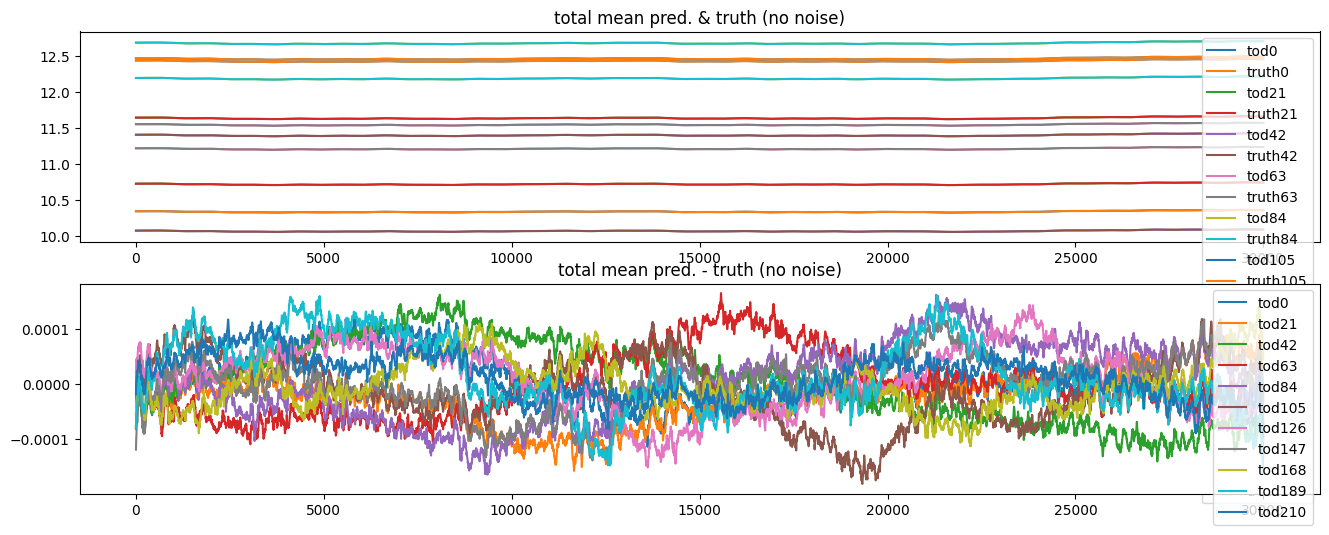

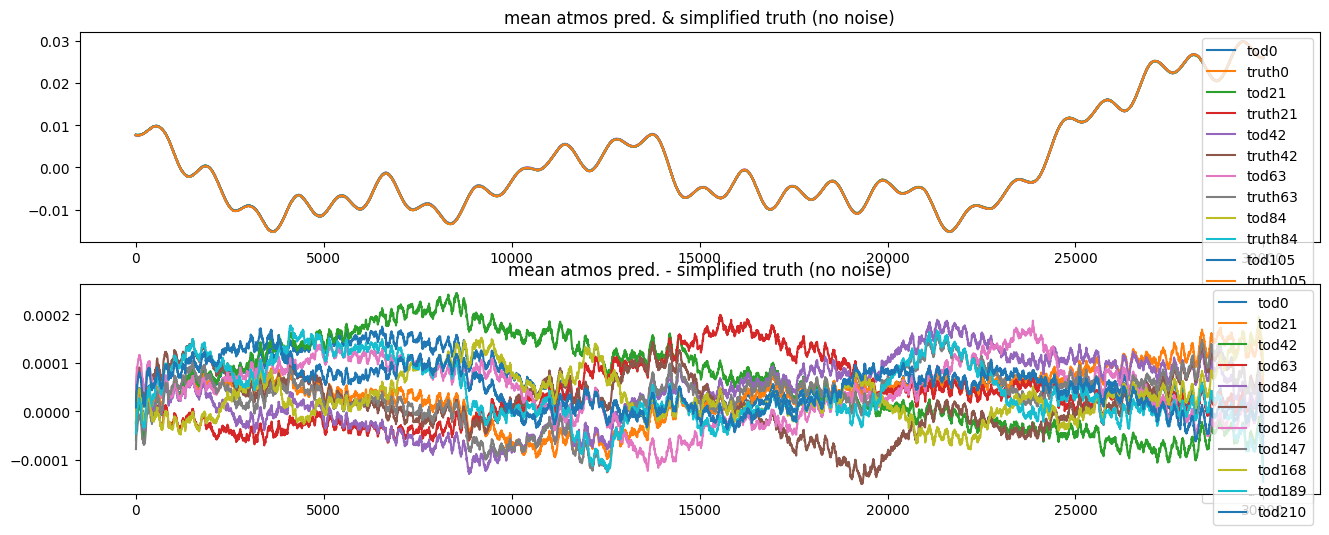

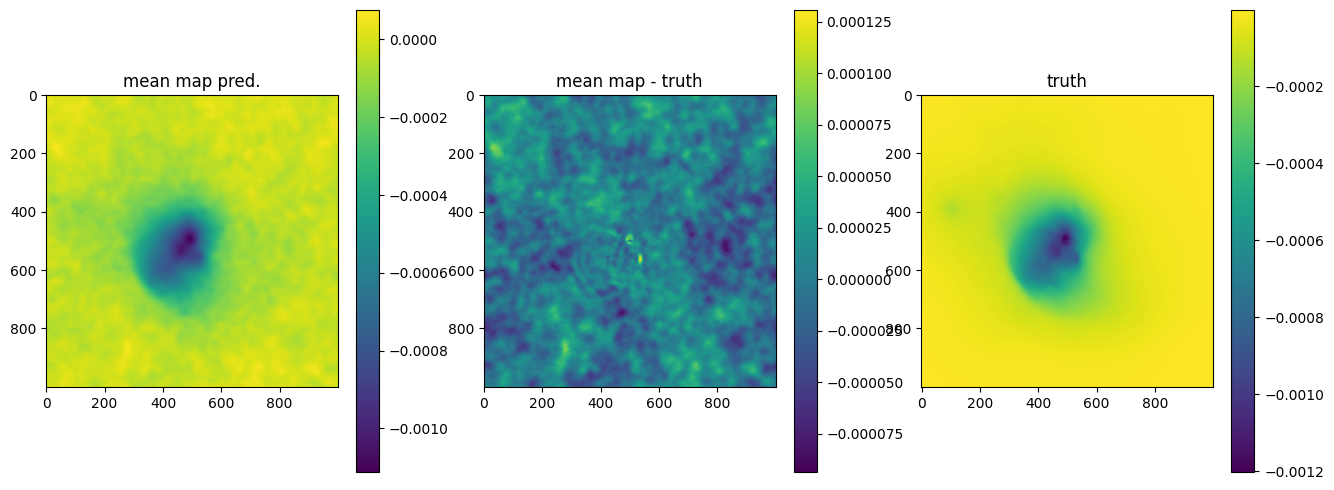

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+6.8096e+07 Δ⛰:inf ➽:1.0400e+01
SL: Iteration 1 ⛰:+4.2545e+07 Δ⛰:2.5552e+07 ➽:1.0400e+01
SL: Iteration 2 ⛰:+4.0391e+07 Δ⛰:2.1534e+06 ➽:1.0400e+01
SL: Iteration 3 ⛰:+3.7489e+06 Δ⛰:3.6642e+07 ➽:1.0400e+01
SL: Iteration 4 ⛰:+8.4162e+05 Δ⛰:2.9073e+06 ➽:1.0400e+01
SL: Iteration 5 ⛰:-1.1861e+06 Δ⛰:2.0277e+06 ➽:1.0400e+01
SL: Iteration 6 ⛰:-2.6992e+06 Δ⛰:1.5131e+06 ➽:1.0400e+01
SL: Iteration 7 ⛰:-2.9705e+06 Δ⛰:2.7130e+05 ➽:1.0400e+01
SL: Iteration 8 ⛰:-2.9766e+06 Δ⛰:6.1077e+03 ➽:1.0400e+01
SL: Iteration 9 ⛰:-3.1877e+06 Δ⛰:2.1107e+05 ➽:1.0400e+01
SL: Iteration 10 ⛰:-3.6153e+06 Δ⛰:4.2764e+05 ➽:1.0400e+01
SL: Iteration 11 ⛰:-3.6231e+06 Δ⛰:7.8493e+03 ➽:1.0400e+01
SL: Iteration 12 ⛰:-3.8498e+06 Δ⛰:2.2670e+05 ➽:1.0400e+01
SL: Iteration 13 ⛰:-3.9338e+06 Δ⛰:8.3987e+04 ➽:1.0400e+01
SL: Iteration 14 ⛰:-4.0487e+06 Δ⛰:1.1490e+05 ➽:1.0400e+01
SL: Iteration 15 ⛰:-4.0498e+06 Δ⛰:1.0994e+03 ➽:1.0400e+01
SL: Iteration 16 ⛰:-4.1302e+06 Δ⛰:8.0322e+04 ➽:1.0400e+01
SL: 

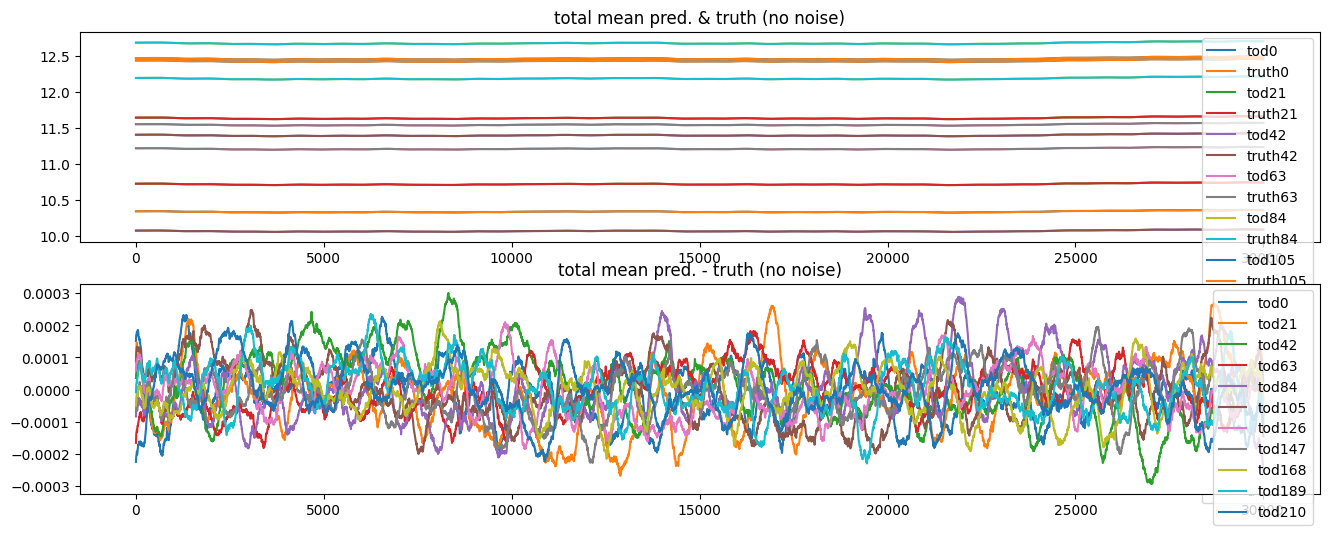

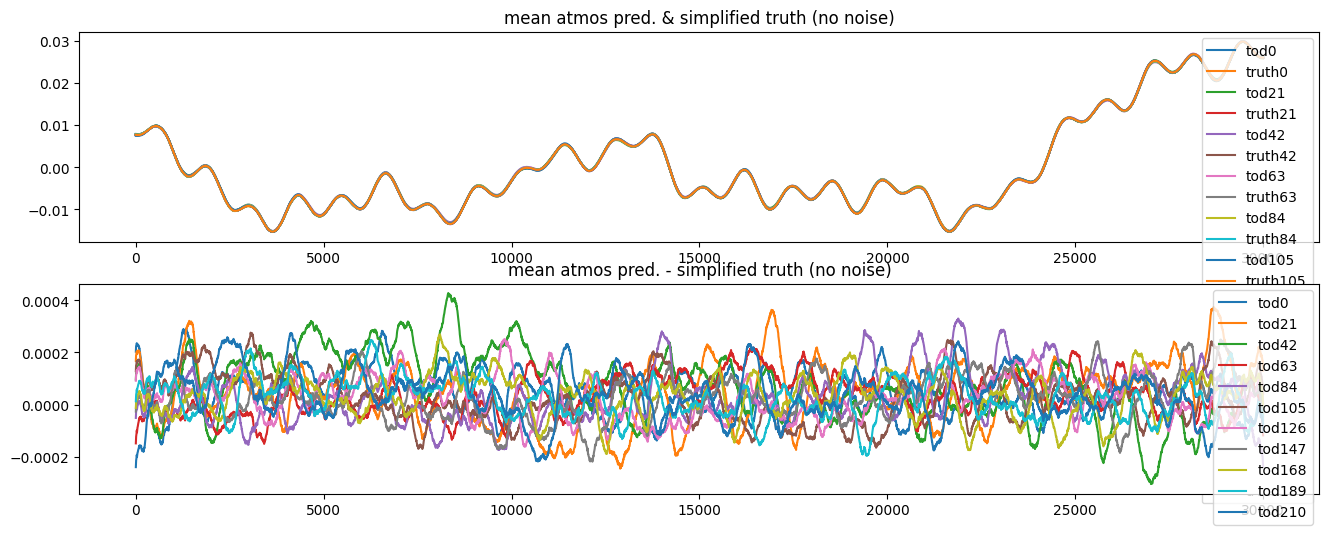

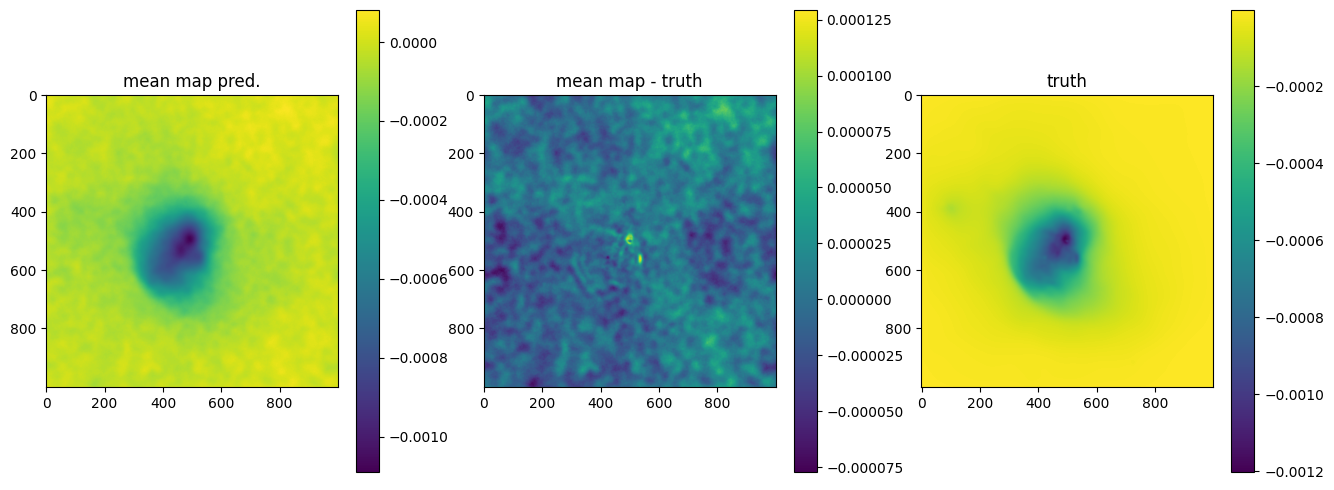

In [36]:
n_it = 2

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    iter = opt_state[0]
    printevery = 1 #10
    if iter % printevery != 0: return

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    for i in range(0, n, n//10):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")
        # axes_tods[0].plot(denoised_jax_tod[i, 100:-100], label=f"truth{i}")
        # axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i, 100:-100], label=f"tod{i}")

    axes_tods[0].title.set_text('total mean pred. & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('total mean pred. - truth (no noise)')
    axes_tods[1].legend()

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    preds = []
    for x in samples:
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = gp_tod(x_tod)

        # From TOD-only fit:
        # preds += [res_tods[:, padding_atmos//2:-padding_atmos//2] * slopes_truth[:, None] + offset_tod_truth[:, None], ]
        preds += [res_tods[:, padding_atmos//2:-padding_atmos//2], ]

    mean_atmos, std = jft.mean_and_std(tuple(preds))

    for i in range(0, n, n//10):
        axes_tods[0].plot(np.arange(0, mean_atmos.shape[1]), mean_atmos[i], label=f"tod{i}")
        # axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[0].plot(atmos_tod_simplified[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean_atmos.shape[1]), mean_atmos[i] - atmos_tod_simplified[i], label=f"tod{i}")
        # axes_tods[1].plot(np.arange(0, mean_atmos.shape[1]), mean[i] - mean_atmos[i], label=f"tod{i}")

    axes_tods[0].title.set_text('mean atmos pred. & simplified truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean atmos pred. - simplified truth (no noise)')
    axes_tods[1].legend()

    fig_map, axes_map = plt.subplots(1, 3, figsize=(16, 6))

    # mean_map, _ = jft.mean_and_std(tuple(gp_map(s)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] for s in samples))
    mean_map, _ = jft.mean_and_std(tuple(gp_map(s) for s in samples))

    im0 = axes_map[0].imshow(mean_map)
    axes_map[0].title.set_text('mean map pred.')
    fig_map.colorbar(im0)

    im1 = axes_map[1].imshow(mean_map - mapdata_truth[0, 0])
    axes_map[1].title.set_text('mean map - truth')
    fig_map.colorbar(im1)

    im2 = axes_map[2].imshow(mapdata_truth[0, 0])
    axes_map[2].title.set_text('truth')
    fig_map.colorbar(im2)

    plt.show()
    

samples, state = jft.optimize_kl(
    # lh, # likelihood
    # jft.Vector(lh.init(k_i)), # initial position in model space (initialisation) # TODO: replace!!
    lh_tod,
    initial_pos,
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=20),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    # sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [37]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.0011142659686557317, 0.0015, 0.0001
	loglogvarslope: -2.7120017753088623, -2.45, 0.1
	zeromode std (LogNormal): 5.846286193632425e-06, 1e-05, 9.9e-06
map:
	fluctuations: 3.7154266483183925e-05, 5.6e-05, 1e-06
	loglogvarslope: -1.8310637131113066, -2.5, 0.1
	zeromode std (LogNormal): 5.697014112131743e-10, 1e-08, 1e-07


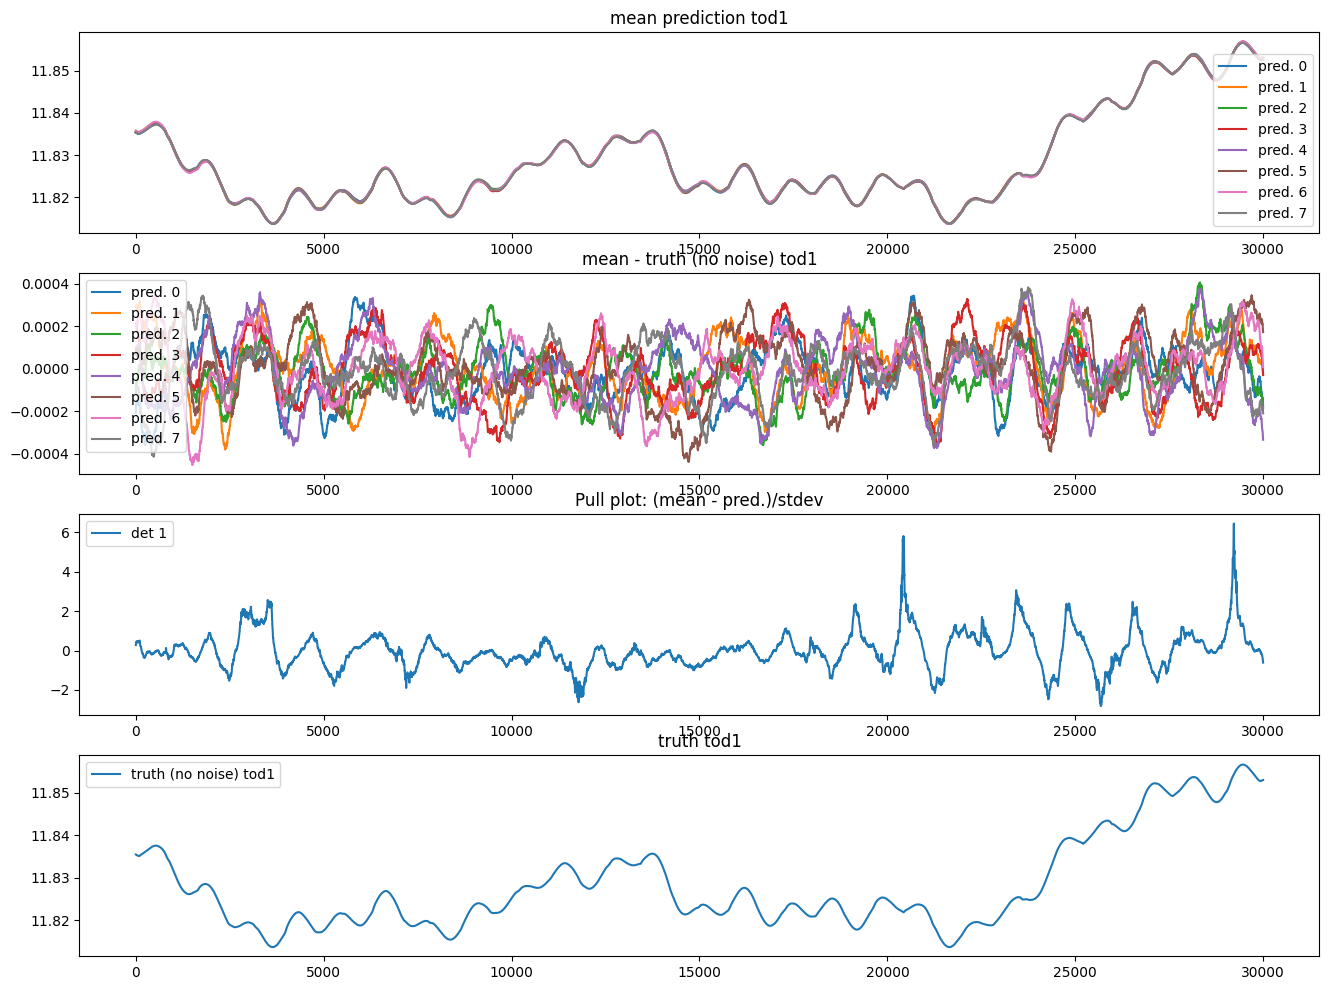

In [38]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

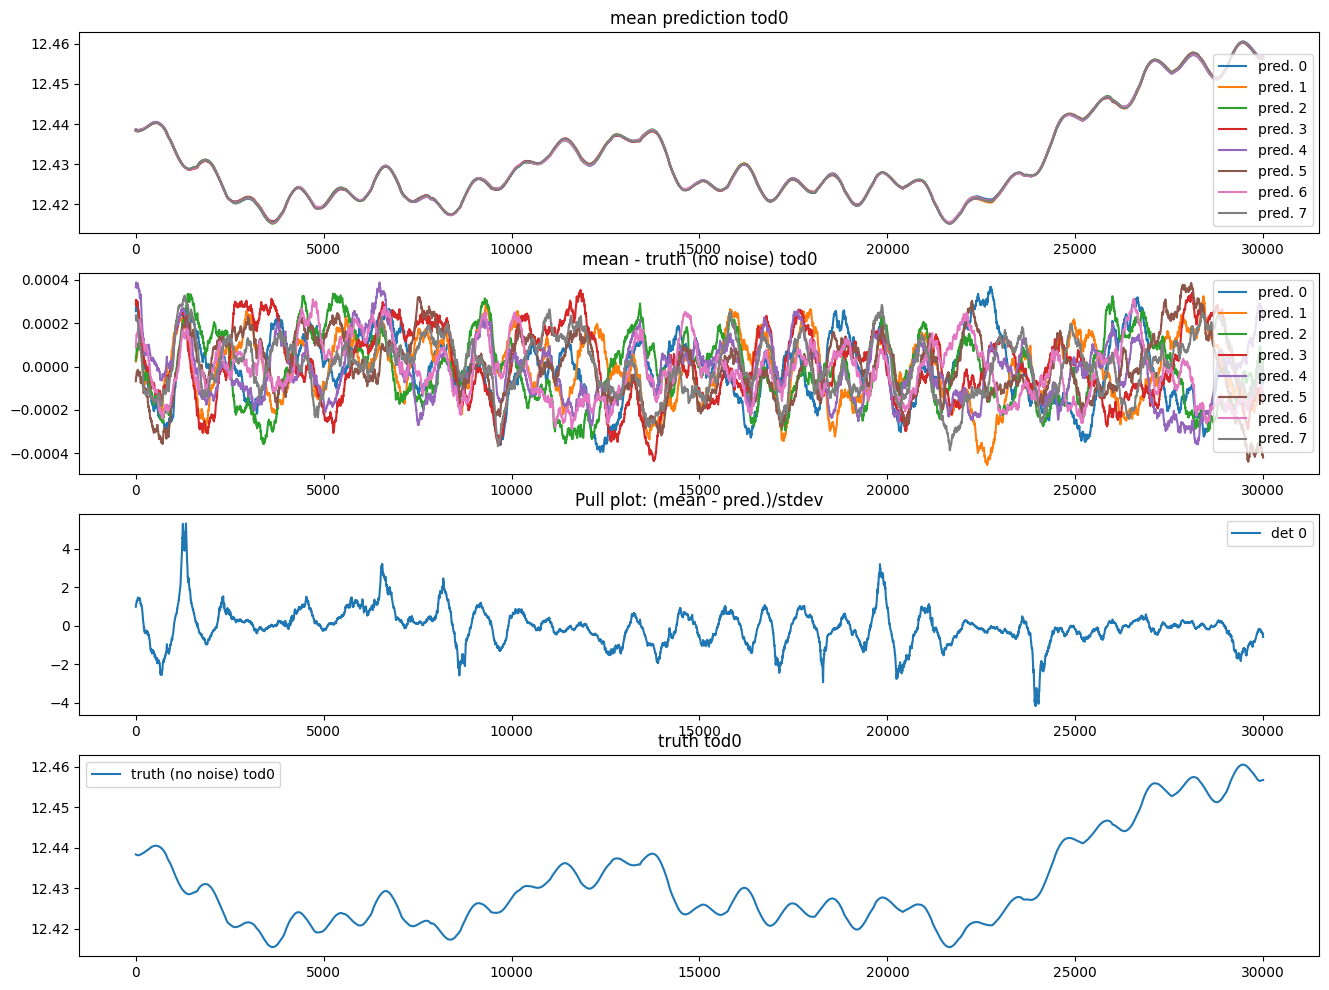

In [39]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

## Compare with maria mapper:

In [40]:
from maria.mappers import BinMapper

mapper = BinMapper(center=(150, 10),
                   frame="ra_dec",
                   width=0.1,
                   height=0.1,
                   resolution=2e-4,
                   tod_preprocessing={
                        "window": {"name": "hamming"},
                        "remove_modes": {"modes_to_remove": [0]},
                        "despline": {"knot_spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod_truthmap)
output_map = mapper.run()

Running mapper (m2/f093): 100%|██████████| 1/1 [00:18<00:00, 18.34s/it]


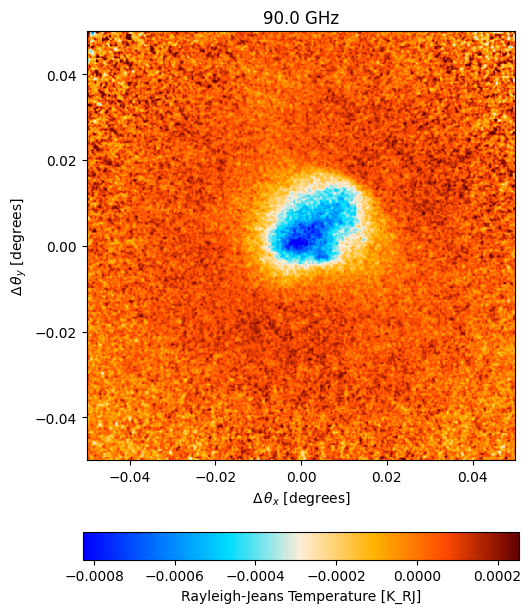

In [41]:
output_map.plot()

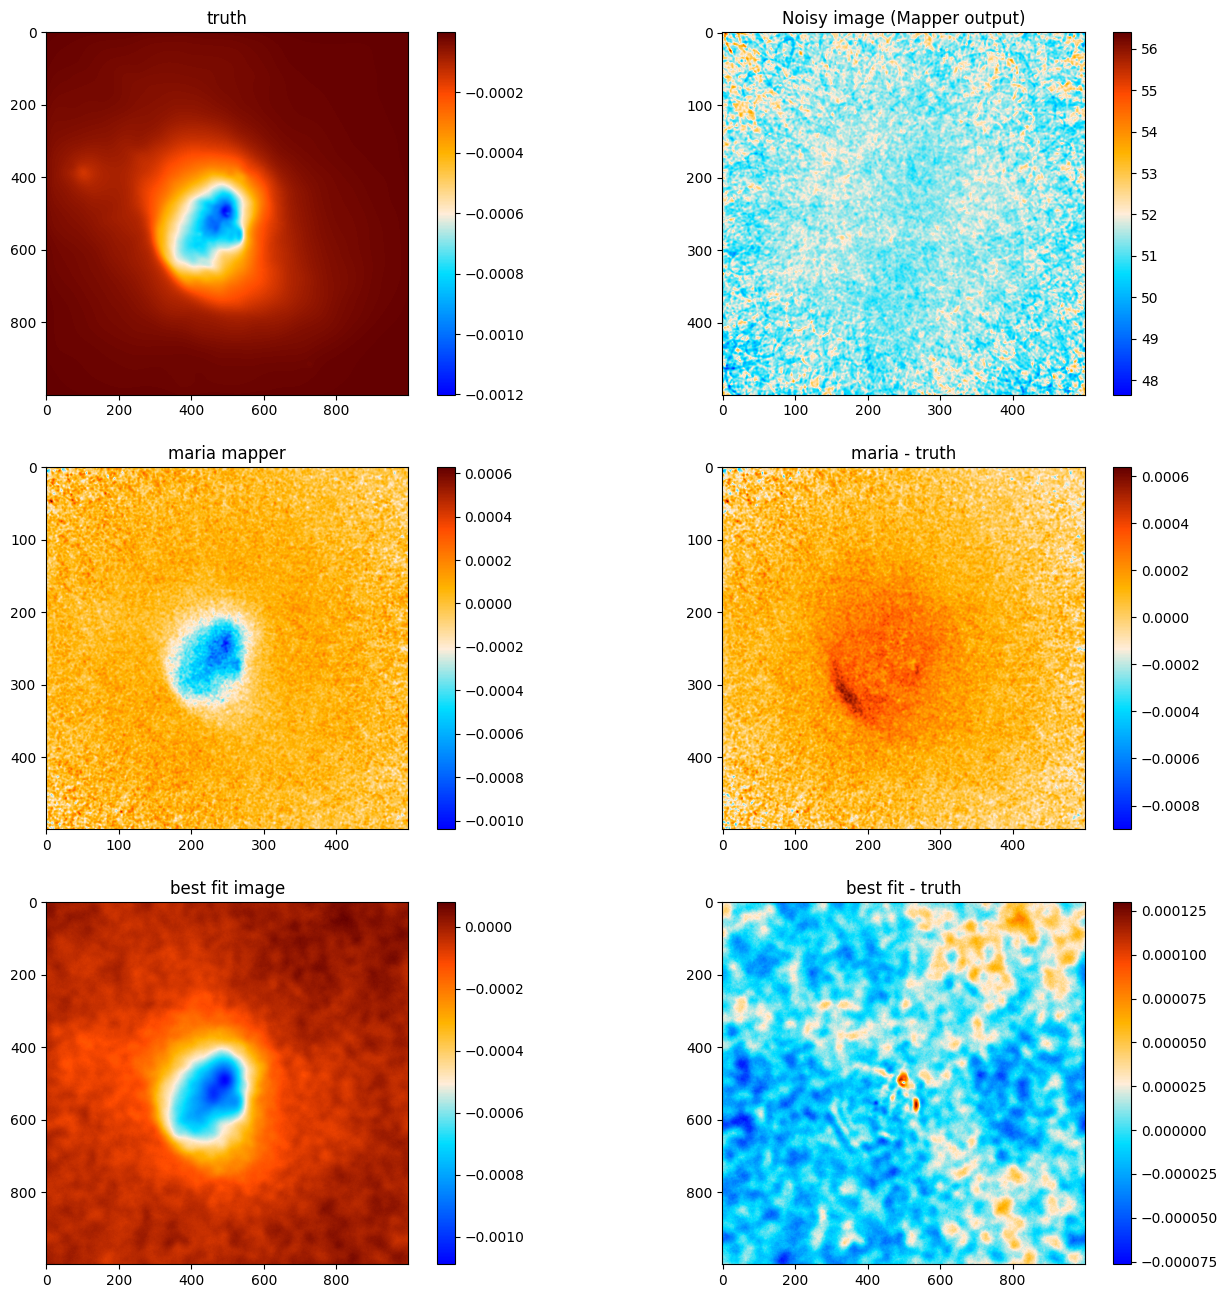

In [42]:
from skimage.transform import resize

# Compare nifty vs maria
# sig_map = gp_map(samples.pos)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] # when splitting up in different field models
sig_map = gp_map(samples.pos)
# mincol = -0.0012
# maxcol = 0.
mincol = None
maxcol = None

cmb_cmap = plt.get_cmap('cmb')
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

im0 = axes[0,0].imshow( mapdata_truth[0,0] , cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[0,0].title.set_text('truth')
fig.colorbar(im0)

im1 = axes[0,1].imshow(output_truthmap.data[0,0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
fig.colorbar(im1)
axes[0,1].title.set_text("Noisy image (Mapper output)")

im2 = axes[1,0].imshow(output_map.data[0, 0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,0].title.set_text('maria mapper')
fig.colorbar(im2)

truth_rescaled = resize(mapdata_truth[0,0], (500, 500), anti_aliasing=True)
im3 = axes[1,1].imshow((output_map.data[0, 0] - truth_rescaled), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,1].title.set_text('maria - truth')
fig.colorbar(im3)

im3 = axes[2,0].imshow(sig_map, cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,0].title.set_text('best fit image')
fig.colorbar(im3)

im4 = axes[2,1].imshow((sig_map - mapdata_truth[0,0]), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,1].title.set_text('best fit - truth')
fig.colorbar(im4)

plt.show()

## Compare with smoothed truth

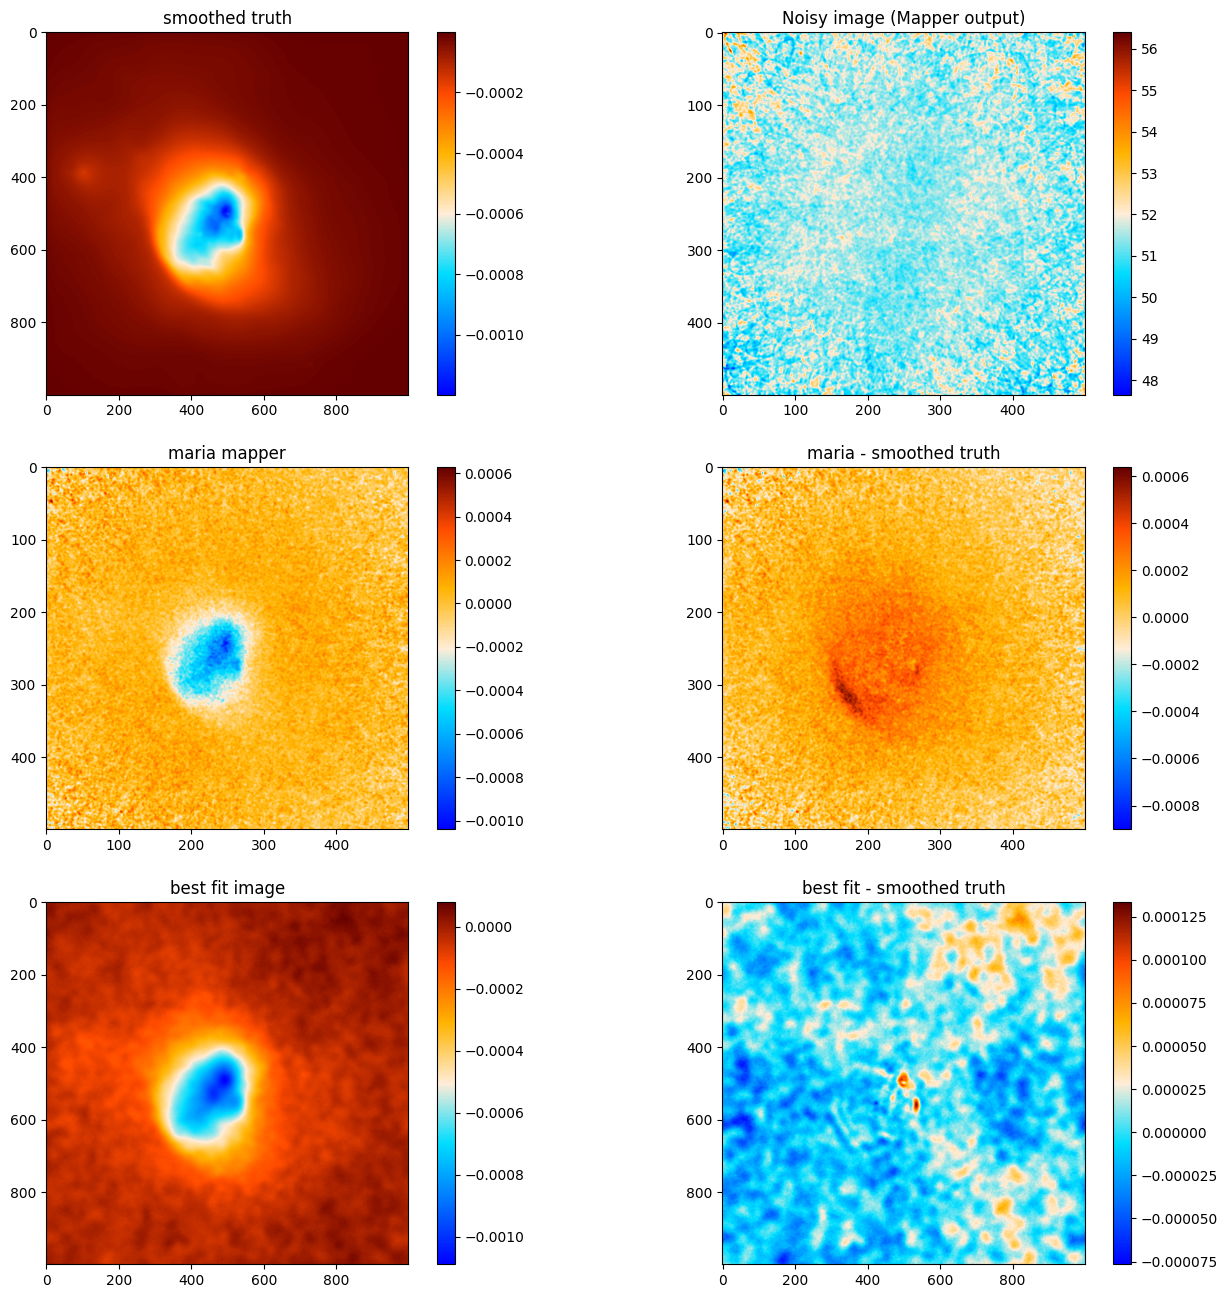

In [43]:
from skimage.transform import resize
from scipy.ndimage import uniform_filter

# Compare nifty vs maria
# sig_map = gp_map(samples.pos)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] # when splitting up in different field models
sig_map = gp_map(samples.pos)
# mincol = -0.0012
# maxcol = 0.
mincol = None
maxcol = None

smoothed_truth = uniform_filter(mapdata_truth[0,0], size=4)
# smoothed_truth = output_map_truth.data[0,0]

cmb_cmap = plt.get_cmap('cmb')
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

im0 = axes[0,0].imshow( smoothed_truth , cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[0,0].title.set_text('smoothed truth')
fig.colorbar(im0)

im1 = axes[0,1].imshow(output_truthmap.data[0,0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
fig.colorbar(im1)
axes[0,1].title.set_text("Noisy image (Mapper output)")

im2 = axes[1,0].imshow(output_map.data[0, 0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,0].title.set_text('maria mapper')
fig.colorbar(im2)

truth_rescaled = resize(smoothed_truth, (500, 500), anti_aliasing=True)
im3 = axes[1,1].imshow((output_map.data[0, 0] - truth_rescaled), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,1].title.set_text('maria - smoothed truth')
fig.colorbar(im3)

im3 = axes[2,0].imshow(sig_map, cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,0].title.set_text('best fit image')
fig.colorbar(im3)

im4 = axes[2,1].imshow((sig_map - smoothed_truth), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,1].title.set_text('best fit - smoothed truth')
fig.colorbar(im4)

plt.show()